In [1]:
from api import api
from sqlalchemy.orm import Query
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def show_images(file_list):
    fig=plt.figure(figsize=(16, 6))
    columns = 5
    rows = 2
    for i in range(1, columns*rows+1):
        img = mpimg.imread(file_list[i-1])
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

In [3]:
api.process_query(Query(api.StyleImage).filter(api.StyleImage.year == 2011).limit(10), 'year2011')

Fetching item 15970
Fetching item 21379
Fetching item 1855
Fetching item 9204
Fetching item 18653
Fetching item 12369
Fetching item 12967
Fetching item 6842
Fetching item 13089
Fetching item 9036


In [4]:
result = api.list_folder('year2011')

In [5]:
result['images']

['/home/andrei/Desktop/imachines/homework/out/year2011/12369.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/12967.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/13089.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/15970.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/1855.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/18653.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/21379.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/6842.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/9036.jpg',
 '/home/andrei/Desktop/imachines/homework/out/year2011/9204.jpg']

In [6]:
result['styles']

['/home/andrei/Desktop/imachines/homework/out/year2011/12369.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/12967.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/13089.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/15970.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/1855.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/18653.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/21379.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/6842.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/9036.json',
 '/home/andrei/Desktop/imachines/homework/out/year2011/9204.json']

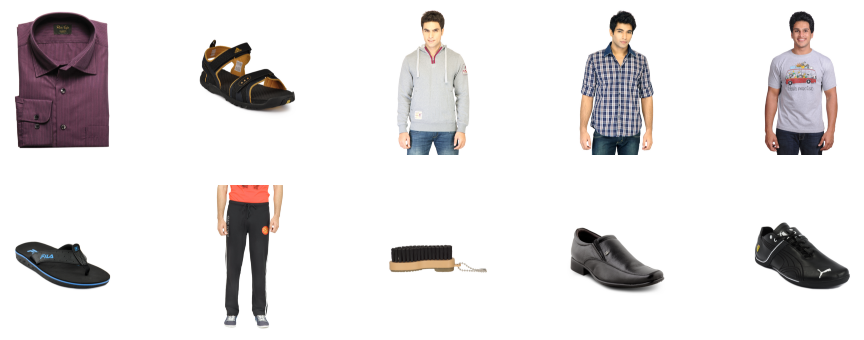

In [7]:
show_images(result['images'])

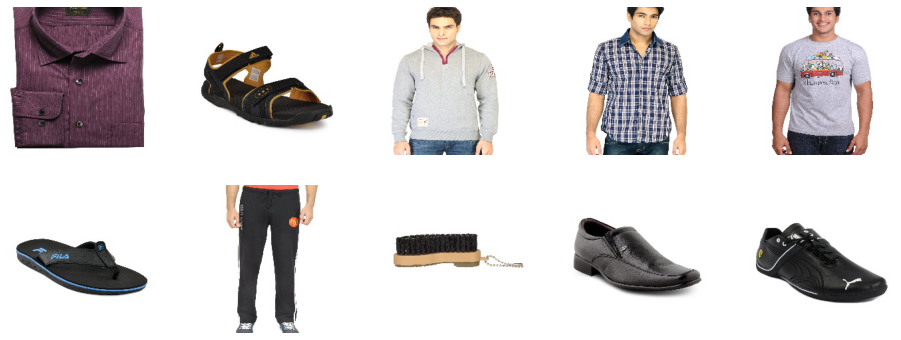

In [8]:
api.transform_folder('year2011', 224)
show_images(api.list_folder('year2011')['augmented_images'])

Fetching item 20099
Fetching item 3954
Fetching item 8574
Fetching item 14856
Fetching item 11385
Fetching item 21174
Fetching item 15341
Fetching item 9835
Fetching item 7193
Fetching item 27283


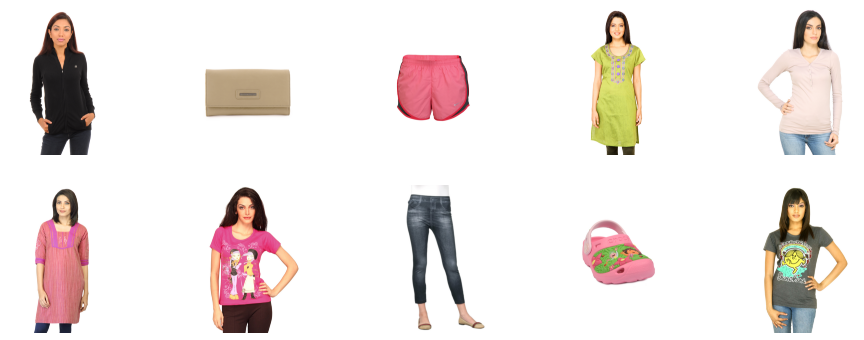

In [9]:
api.process_query(Query(api.StyleImage).filter(api.StyleImage.year == 2011)\
                  .filter(api.StyleImage.gender == 'Women').limit(10), 'women-year2011')
show_images(api.list_folder('women-year2011')['images'])

In [10]:
import torch
import torchvision
from torchvision import transforms as transforms

In [11]:
# ssl fix for ubuntu to download pre-trained model
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [12]:
model_ft = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_ft.to(0)
model_ft.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [17]:
import numpy as np
img = np.ndarray([mpimg.imread(im_path) for im_path in api.list_folder('year2011')['images']])

TypeError: only integer scalar arrays can be converted to a scalar index

In [15]:
img_t = transforms.ToTensor()(img).to(0)
batch_t = torch.unsqueeze(img_t, 0)

TypeError: pic should be PIL Image or ndarray. Got <class 'list'>

In [ ]:
import gc
prediction = {'boxes':[],'labels':[]}
with torch.no_grad():
    temp = model_ft(batch_t)
    prediction = {'boxes':temp[0]['boxes'].to('cpu'),'labels':temp[0]['labels'].to('cpu')}
    del temp
    torch.cuda.empty_cache()
    gc.collect()


In [ ]:
prediction

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
import cv2

for i in range(len(prediction['boxes'])):
    x1, x2, x3, x4 = map(int, prediction['boxes'][i].tolist())
    cl = prediction['labels'][i]
    
    (test_width, text_height), baseline = cv2.getTextSize(COCO_INSTANCE_CATEGORY_NAMES[cl],
                                                              cv2.FONT_HERSHEY_SIMPLEX,
                                                              2, 1)
    cv2.rectangle(img, (x1, x2), (x3, x4), (255, 0, 0), 2)
    cv2.putText(img, COCO_INSTANCE_CATEGORY_NAMES[cl], (x1, x2 - baseline), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2) 
    
plt.figure(figsize=(8,10))
plt.axis('off')
plt.imshow(img)